In [80]:
import pandas as pd
data=pd.read_csv("FAOLEX_All.csv")
print(data.keys())

Index(['Record Id', 'Record URL', 'Document URL', 'Title', 'Original title',
       'Date of original text', 'Last amended date', 'Available website',
       'Language of document', 'Country/Territory', 'Regional organizations',
       'Territorial subdivision', 'Type of text', 'Repealed', 'Abstract',
       'Primary subjects', 'Domain', 'Keywords'],
      dtype='object')


In [79]:
#country data
income = pd.read_excel("CLASS.xlsx")
print(income.keys())

Index(['Economy', 'Code', 'Region', 'Income group', 'Lending category',
       'Other (EMU or HIPC)'],
      dtype='object')


In [59]:
import nltk
keywords_nofilter=list(data["Keywords"])
country_nofilter=list(data["Country/Territory"])
i=0
# Split alle keywords op i en liste og ændrer nan til at være en str med Nan
for words in keywords_nofilter:
    if type(words)!=str:
        #print("type= ",type(words)," Index = ", i)
        words="NaN"
    if type(country_nofilter[i])!=str:
        country_nofilter[i]="NaN"
    keywords_nofilter[i]=words.split(";")
    i+=1



In [60]:
#Remove Nan from keywords and countries
keywords = []
country = []

for i in range(len(keywords_nofilter)):
    if keywords_nofilter[i] != ["NaN"] and country_nofilter[i]!="NaN":
        keywords.append(keywords_nofilter[i])
        country.append(country_nofilter[i])


In [61]:
from nltk.stem import SnowballStemmer
from nltk.tokenize import word_tokenize
import numpy as np
stemmer = SnowballStemmer("english")
stemmed_words=[]
for i in range(len(keywords)):
    stemmed_words.append([stemmer.stem(word) for word in keywords[i]])



In [62]:
print(keywords[15])
print(stemmed_words[15])


['marine fisheries', ' traditional rights/customary rights', ' fishing authorization', ' allocation/quota', ' fishery management and conservation']
['marine fisheri', ' traditional rights/customary right', ' fishing author', ' allocation/quota', ' fishery management and conserv']


# Top2vec topic model

In [63]:
# Make a top2vec topic model
from top2vec import Top2Vec
i=0
for word in keywords:
    keywords[i]="".join(word)
    i+=1
model = Top2Vec(keywords,embedding_model="doc2vec")


2023-06-07 15:02:06,608 - top2vec - INFO - Pre-processing documents for training
2023-06-07 15:02:15,746 - top2vec - INFO - Creating joint document/word embedding
2023-06-07 15:08:14,019 - top2vec - INFO - Creating lower dimension embedding of documents
2023-06-07 15:09:45,346 - top2vec - INFO - Finding dense areas of documents
2023-06-07 15:10:03,479 - top2vec - INFO - Finding topics


## Country co-occurence

- For hver tekst, find tilhørende topic --> noter landet til denne topic

In [64]:
# Compute unqie countries --> i.e. remove agreement "countries" 
country_new=[]
for coun in country:
    if len(coun.split(";"))>=2:
        for c in coun.split("; "):
            country_new.append(c)
    else:
        country_new.append(coun)

In [65]:
# Make country dict --> key: country, value: country index
countries = {}
i=0
for country_x in (list(set(country_new))):
    countries[country_x]=i
    i+=1

In [66]:
# Compute country co-occurence matrix
topic_sizes, topic_nums = model.get_topic_sizes()

country_topic_matrix = np.zeros((len(set(country_new)),len(topic_nums)))

for num in topic_nums:
    # For each topic get the corresponding documents
    documents, document_scores, document_ids = model.search_documents_by_topic(topic_num=num,num_docs=topic_sizes[num])
    for id in document_ids:
        # Find the documents' countries and add it to the co-occurence matrix
        if len(country[id].split(";"))>=2:
            for c in country[id].split("; "):
                 country_topic_matrix[countries[c],num] +=1
        else:
            country_topic_matrix[countries[country[id]],num] +=1


In [67]:
#Standardisering
"""
def get_swap_dict(d):
    return {v: k for k, v in d.items()}

countries_swap = get_swap_dict(countries)
for i in range(len(countries)):
    country_topic_matrix[i,:]=country_topic_matrix[i,:]/country_new.count(countries_swap[i])

"""

'\ndef get_swap_dict(d):\n    return {v: k for k, v in d.items()}\n\ncountries_swap = get_swap_dict(countries)\nfor i in range(len(countries)):\n    country_topic_matrix[i,:]=country_topic_matrix[i,:]/country_new.count(countries_swap[i])\n\n'

In [68]:
def square_rooted(x):
   return round(np.sqrt(sum([a*a for a in x])),3)

def cosine_similarity(x,y):
 numerator = sum(a*b for a,b in zip(x,y))
 denominator = square_rooted(x)*square_rooted(y)
 return round(numerator/float(denominator),3)




In [69]:
def co_occurence(country_new,similarity):
    country_co_ocurrence = np.zeros((len(set(country_new)),len(set(country_new))))
    for i in range(len(set(country_new))):
        for j in range(len(set(country_new))):
            if similarity == "correlation":
                # Correlation
                country_co_ocurrence[i,j] = np.corrcoef(country_topic_matrix[i,:],country_topic_matrix[j,:])[0,1]
            elif similarity == "cosine":
                #Cosine similarity:
                country_co_ocurrence[i,j] = cosine_similarity(country_topic_matrix[i,:], country_topic_matrix[j,:])
    return country_co_ocurrence

country_co_ocurrence = co_occurence(country_new,"correlation")
np.shape(country_co_ocurrence)



(257, 257)

Country Network


In [70]:
# swap dict

def get_swap_dict(d):
    return {v: k for k, v in d.items()}

countries_swap = get_swap_dict(countries)

print(countries_swap)


{0: 'Réunion (France)', 1: 'Taiwan Province of China', 2: 'Iran (Islamic Republic of)', 3: 'Republic of Korea', 4: 'Viet Nam', 5: 'Venezuela (Bolivarian Republic of)', 6: 'Solomon Islands', 7: 'Trinidad and Tobago', 8: 'Suriname', 9: 'Uzbekistan', 10: 'Rwanda', 11: 'Niger', 12: 'Hungary', 13: 'Svalbard (Norway)', 14: 'MERCOSUR', 15: 'Fiji', 16: 'American Samoa (USA)', 17: 'Saint Barthélemy (FRA)', 18: 'Estonia', 19: 'Sweden', 20: 'Guam (USA)', 21: 'Comoros', 22: 'Algeria', 23: 'Saint Martin (France)', 24: 'Angola', 25: 'Portugal', 26: 'Somalia', 27: 'Libya', 28: 'Bosnia and Herzegovina', 29: 'San Marino', 30: 'Italy', 31: 'Liechtenstein', 32: 'Tromelin Island (France)', 33: 'Malawi', 34: 'Ghana', 35: "Lao People's Democratic Republic", 36: 'Mali', 37: 'Mexico', 38: 'Åland Islands (Finland)', 39: 'Chad', 40: 'Saint Vincent and the Grenadines', 41: 'Belgium', 42: 'Romania', 43: 'South Sudan', 44: 'Jersey  (UK)', 45: 'Turks and Caicos Islands (UK)', 46: 'British Virgin Islands (UK)', 47: 

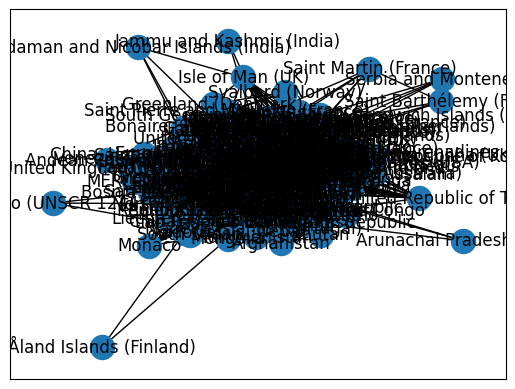

In [71]:

from networkx.algorithms.community import girvan_newman
import networkx as nx
import itertools
import matplotlib.pyplot as plt

G = nx.Graph()

size = country_co_ocurrence.shape[0]


G.add_nodes_from(range(size))

for i in range(size):
        for j in range(i+1, size):
            #if country_co_ocurrence[i, j] != 0.0:
            if country_co_ocurrence[i, j] > 0.15:
                G.add_edge(i, j, weight=country_co_ocurrence[i, j])


nx.draw_networkx(G, labels=countries_swap,with_labels=True)
#nx.draw_spring(G, labels=countries_swap,with_labels=True)




In [72]:
#Louvain method

In [73]:

from networkx.algorithms.community import louvain_communities
comms = louvain_communities(G,weight="weight",resolution=2)
unique_coms = np.unique(list(comms))


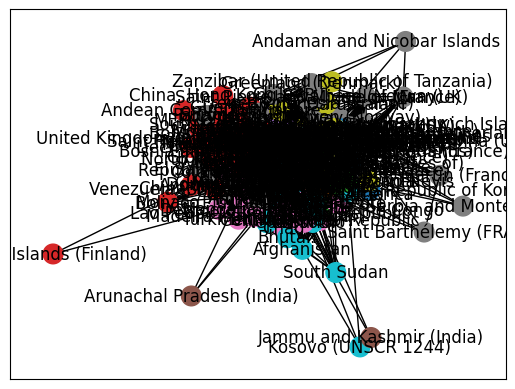

In [74]:
community_assignment = {}

# Assign community indices to nodes
for i, community in enumerate(comms):
    for node in community:
        community_assignment[node] = i

# Create a list of colors for each node based on the community assignment
node_colors = [community_assignment.get(node, -1) for node in G.nodes()]

# Draw the graph with different colors for different communities
pos = nx.spring_layout(G)  # Positions of nodes in the graph layout
nx.draw_networkx_nodes(G, pos, node_color=node_colors, cmap=plt.cm.tab10, node_size=200)
nx.draw_networkx_edges(G, pos)
nx.draw_networkx_labels(G, pos,labels=countries_swap)
plt.show()

In [75]:
i=1

for community in comms:
    print("c",i)
    for country in community:
        print(countries_swap[country])

    i=i+1

c 1
Tuvalu
Marshall Islands
Kiribati
Democratic People's Republic of Korea
Nauru
Cook Islands
Palau
c 2
Denmark
Sweden
c 3
Cabo Verde
Tunisia
Sri Lanka
c 4
Finland
c 5
Namibia
c 6
Haiti
Myanmar
c 7
Eritrea
Iceland
Thailand
c 8
Iran (Islamic Republic of)
c 9
Indonesia
Solomon Islands
Comoros
Liberia
Suriname
Equatorial Guinea
Gambia
c 10
China, Hong Kong SAR
Germany
Taiwan Province of China
Croatia
MERCOSUR
Estonia
European Union
Portugal
Czechia
Bosnia and Herzegovina
San Marino
United Kingdom of Great Britain and Northern Ireland
Italy
Liechtenstein
Åland Islands (Finland)
Belgium
Andorra
South Africa
Malta
France
Luxembourg
Austria
Lebanon
Greece
Spain
Türkiye
China, Macao SAR
Andean Community
Cyprus
Gibraltar (UK)
North Macedonia
Ireland
Guernsey (UK)
Monaco
Slovakia
Serbia
Poland
Bulgaria
Switzerland
Montenegro
Slovenia
Latvia
c 11
Seychelles
c 12
Morocco
c 13
Jordan
Jersey  (UK)
Kuwait
Israel
Palestine
Bahrain
Qatar
Egypt
United Arab Emirates
Oman
Iraq
Syrian Arab Republic
c 14
Ma

In [121]:

c = 0
income_countries = income["Economy"].head(218).tolist()
listed_countries = []
for i in range(len(countries_swap)):
    listed_countries.append(countries_swap[i])


for i in range(len(income_countries)):
    for j in range(len(countries_swap)):
        if income_countries[i] == countries_swap[j]:
            c += 1


In [122]:

missing = []
for i in range(len(countries_swap)):
    if countries_swap[i] not in income_countries:
        missing.append(countries_swap[i])
print(missing)


['Réunion (France)', 'Taiwan Province of China', 'Iran (Islamic Republic of)', 'Republic of Korea', 'Viet Nam', 'Venezuela (Bolivarian Republic of)', 'Svalbard (Norway)', 'MERCOSUR', 'American Samoa (USA)', 'Saint Barthélemy (FRA)', 'Guam (USA)', 'Saint Martin (France)', 'Tromelin Island (France)', "Lao People's Democratic Republic", 'Åland Islands (Finland)', 'Saint Vincent and the Grenadines', 'Jersey  (UK)', 'Turks and Caicos Islands (UK)', 'British Virgin Islands (UK)', 'Palestine', 'Yemen', 'Aruba (Netherlands)', 'Tokelau (New Zealand)', 'Kosovo (UNSCR 1244)', 'Jammu and Kashmir (India)', 'Andaman and Nicobar Islands (India)', 'Northern Mariana Islands (USA)', 'New Caledonia (France)', 'Faroe Islands (Denmark)', 'Pitcairn (UK)', 'Europa Island (France)', 'Andean Community', 'Saint Lucia', 'Falkland Islands (Malvinas)', 'Gibraltar (UK)', 'Isle of Man (UK)', 'Gambia', 'Egypt', 'Guernsey (UK)', 'Greenland (Denmark)', 'Zanzibar (United Republic of Tanzania)', 'French Polynesia (France

In [120]:
from fuzzywuzzy import process
matches = []
threshold = 90  # Adjust the threshold as per your needs

for country1 in listed_countries:
    best_match = process.extractOne(country1, income_countries)
    if best_match[1] >= threshold:
        matches.append((country1, best_match[0]))


# Print the matches
for match in matches:
    print("Match:", match[0], "-", match[1])

print(len(matches))
print("matches found")

Match: Réunion (France) - France
Match: Taiwan Province of China - China
Match: Viet Nam - Vietnam
Match: Solomon Islands - Solomon Islands
Match: Trinidad and Tobago - Trinidad and Tobago
Match: Suriname - Suriname
Match: Uzbekistan - Uzbekistan
Match: Rwanda - Rwanda
Match: Niger - Niger
Match: Hungary - Hungary
Match: Svalbard (Norway) - Norway
Match: Fiji - Fiji
Match: American Samoa (USA) - American Samoa
Match: Estonia - Estonia
Match: Sweden - Sweden
Match: Guam (USA) - Guam
Match: Comoros - Comoros
Match: Algeria - Algeria
Match: Saint Martin (France) - France
Match: Angola - Angola
Match: Portugal - Portugal
Match: Somalia - Somalia
Match: Libya - Libya
Match: Bosnia and Herzegovina - Bosnia and Herzegovina
Match: San Marino - San Marino
Match: Italy - Italy
Match: Liechtenstein - Liechtenstein
Match: Tromelin Island (France) - France
Match: Malawi - Malawi
Match: Ghana - Ghana
Match: Mali - Mali
Match: Mexico - Mexico
Match: Åland Islands (Finland) - Finland
Match: Chad - Cha